In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 수수료

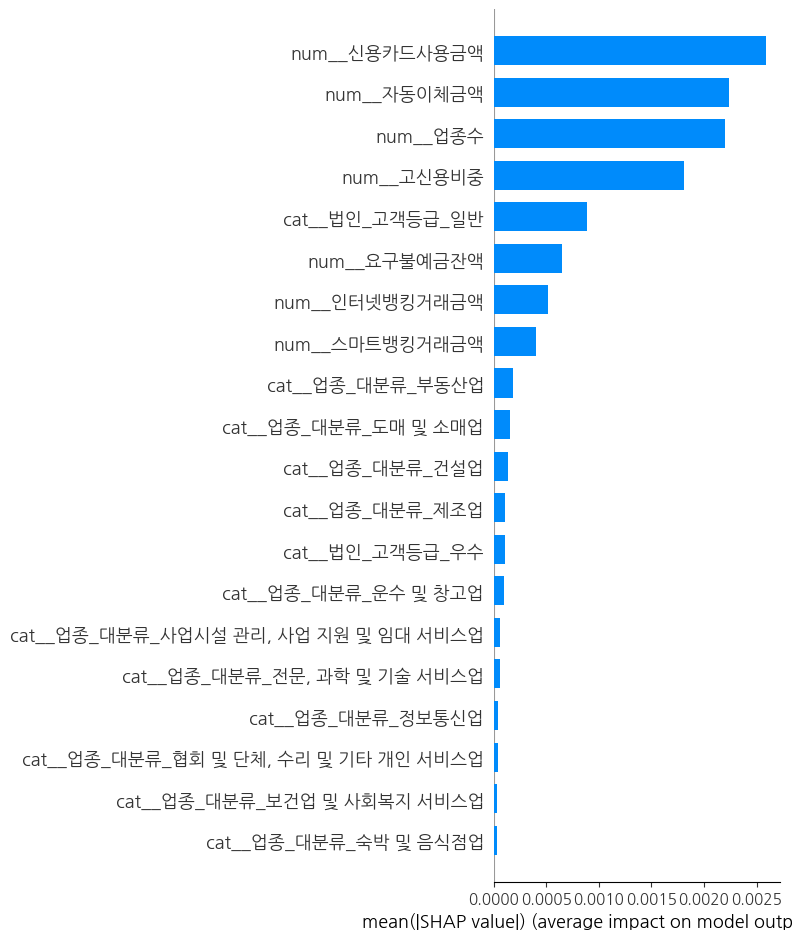


📌 수수료 수익 결정 변수 영향도 (SHAP 기준 Top 10)
                      변수  SHAP 영향력
4          num__신용카드사용금액  0.002593
1            num__자동이체금액  0.002237
6               num__업종수  0.002197
5             num__고신용비중  0.001805
26       cat__법인_고객등급_일반  0.000887
0           num__요구불예금잔액  0.000651
3         num__인터넷뱅킹거래금액  0.000517
2         num__스마트뱅킹거래금액  0.000406
14      cat__업종_대분류_부동산업  0.000182
12  cat__업종_대분류_도매 및 소매업  0.000149


In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 수수료 수익 데이터 불러오기 (FISIS)
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")

fee_target_df = (
    fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "수수료수익:당분기")]
    .drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    .T.rename(columns={fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "수수료수익:당분기")].index[0]: "수수료수익"})
)
fee_target_df.index = pd.to_datetime(fee_target_df.index, format="%Y년%m월")
fee_target_df = fee_target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})     # 선형보간(월 초 기준으로 보간됨)

# -----------------------------
# 2. 내부 법인 데이터 불러오기
# -----------------------------
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

# -----------------------------
# 3. 병합 및 타깃 재정의 (수수료수익 / 고객수)
# -----------------------------
merged = pd.merge(df, fee_target_df, on="기준년월", how="inner")
merged = merged.dropna(subset=["수수료수익"])

# 기준년월당 고객 수 계산
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]

# 고객 1인당 수수료 수익 → log 변환
merged["수수료_per고객"] = merged["수수료수익"] / merged["고객수"]
y = np.log1p(merged["수수료_per고객"])  # 안정화 목적

# -----------------------------
# 4. 설명변수 정의 및 파생변수 생성
# -----------------------------
merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "요구불예금잔액", "자동이체금액", "스마트뱅킹거래금액", 
    "인터넷뱅킹거래금액", "신용카드사용금액", "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]

X = merged[features]

# -----------------------------
# 5. 전처리 및 XGBoost 모델 학습
# -----------------------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = list(set(features) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("xgb", xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42))
])

pipeline.fit(X, y)

# -----------------------------
# 6. SHAP 해석
# -----------------------------
explainer = shap.TreeExplainer(pipeline.named_steps["xgb"])
X_prepared = preprocessor.fit_transform(X)
shap_values = explainer.shap_values(X_prepared)

# SHAP summary plot
shap.summary_plot(
    shap_values,
    X_prepared,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="bar"
)

# -----------------------------
# 7. 변수 영향도 테이블 출력
# -----------------------------
mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    "변수": preprocessor.get_feature_names_out(),
    "SHAP 영향력": mean_abs_shap
}).sort_values(by="SHAP 영향력", ascending=False)

print("\n📌 수수료 수익 결정 변수 영향도 (SHAP 기준 Top 10)")
print(importance_df.head(10))

## 📌 SHAP 결과 해석 요약
| 순위  | 변수               | SHAP 영향력 | 해석                                                          |
| --- | ---------------- | -------- | ----------------------------------------------------------- |
| 1️⃣ | **신용카드사용금액**     | 0.00259  | **가장 강한 영향력**. 고객 카드 사용량이 많을수록 수수료 수익 상승. 카드결제 기반 수수료 구조 기여 |
| 2️⃣ | **자동이체금액**       | 0.00224  | 자동납부/지로 이용 활성화 고객일수록 수수료 수익 증가. 정기적인 금융활동이 중요               |
| 3️⃣ | **업종수**          | 0.00220  | 업종 다양성이 클수록 수익 증가 → **고객 포트폴리오 다양성 확보** 중요                  |
| 4️⃣ | **고신용비중**        | 0.00180  | 최우수 고객 비중이 높을수록 수수료 수익 기여↑. **우량고객 중심 수수료 전략 필요**           |
| 5️⃣ | **법인\_고객등급\_일반** | 0.00089  | 일반 등급 고객도 수익성에 기여. 이들을 **중간전략 타깃**으로 고려 가능                  |
| 6️⃣ | **요구불예금잔액**      | 0.00065  | 자금 회전율 높은 고객이 수익에도 기여. 유동성 높은 예금 기반 수익화 가능                  |
| 7️⃣ | **인터넷뱅킹거래금액**    | 0.00052  | 비대면 인터넷 사용 고객도 수수료 수익 기여                                    |
| 8️⃣ | **스마트뱅킹거래금액**    | 0.00041  | 모바일 이용 기반 고객도 기여는 있음 (상대적으로 낮음)                             |
| 9️⃣ | **업종: 부동산업**     | 0.00018  | 업종 중 부동산업 고객이 수익에 다소 기여                                     |
| 🔟  | **업종: 도매 및 소매업** | 0.00015  | 이 역시 중간 수준 기여                                               |

## 🎯 정책 설계 타깃 도출 예시
| 정책 제안                    | 근거 변수                 | 기대 효과                         |
| ------------------------ | --------------------- | ----------------------------- |
| 💳 **신용카드 기반 수수료 강화 전략** | `신용카드사용금액`            | 가장 강한 영향 → 카드 중심 수익 구조 확대     |
| 🔁 **자동이체 유도 캠페인**       | `자동이체금액`              | 높은 기여도 → **정기결제 유도 전략 설계 필요** |
| 🧠 **우량고객 집중 전략**        | `고신용비중`, `법인_고객등급_일반` | 고신용자 타깃 우선 / 일반고객도 병행 활용 가능   |
| 🏢 **업종 다변화 고객 확대**      | `업종수`                 | 다양한 업종 보유 → 수익 안정화 기여         |
| 🌐 **비대면 채널 보완정책**       | `인터넷/스마트뱅킹거래금액`       | 온라인 이용 고객 기반 수익 성장 전략         |

## ✅ 종합 메시지
수수료 수익 확대를 위해서는 신용카드 기반 활동성 높은 고객과, 자동이체·인터넷뱅킹 등 디지털 채널 이용 고객을 확보하는 것이 핵심이며, 업종 다양성과 고신용 고객 비중을 유지하는 것이 정책 설계 타깃으로 유효함.

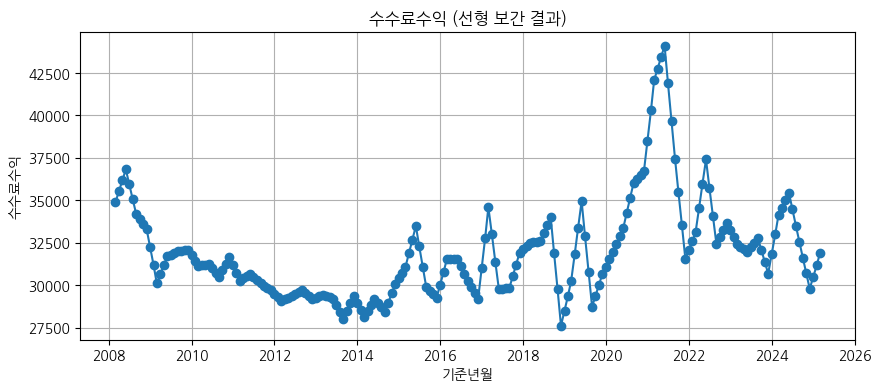

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(fee_target_df["기준년월"], fee_target_df["수수료수익"], marker='o')
plt.title("수수료수익 (선형 보간 결과)")
plt.xlabel("기준년월")
plt.ylabel("수수료수익")
plt.grid(True)
plt.show()


# 신탁

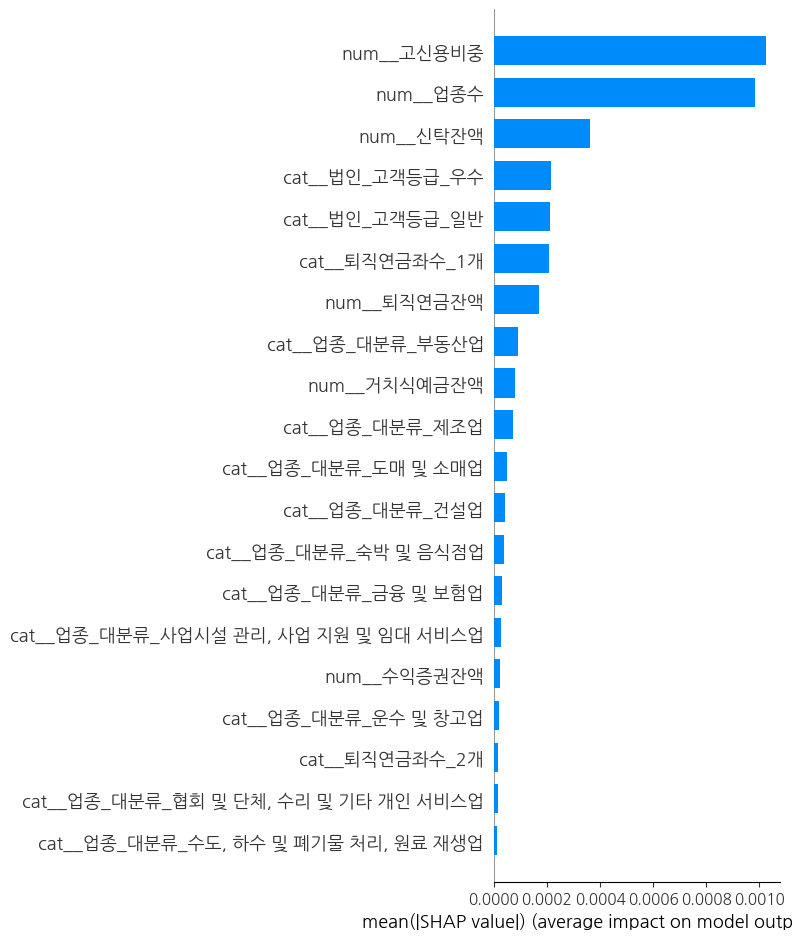


📌 신탁 수익 결정 변수 영향도 (SHAP 기준 Top 10)
                  변수  SHAP 영향력
4         num__고신용비중  0.001026
5           num__업종수  0.000982
0          num__신탁잔액  0.000364
24   cat__법인_고객등급_우수  0.000214
25   cat__법인_고객등급_일반  0.000212
28    cat__퇴직연금좌수_1개  0.000208
1        num__퇴직연금잔액  0.000168
13  cat__업종_대분류_부동산업  0.000092
3       num__거치식예금잔액  0.000078
22   cat__업종_대분류_제조업  0.000073


In [31]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 신탁 수익 데이터 불러오기 (FISIS)
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")

trust_target_df = (
    fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "신탁(은행계정) 관련 손익:당분기")]
    .drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    .T.rename(columns={fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "신탁(은행계정) 관련 손익:당분기")].index[0]: "신탁수익"})
)
trust_target_df.index = pd.to_datetime(trust_target_df.index, format="%Y년%m월")
trust_target_df = trust_target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

# -----------------------------
# 2. 내부 법인 데이터 불러오기
# -----------------------------
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

# -----------------------------
# 3. 병합 및 타깃 재정의 (신탁수익 / 고객수)
# -----------------------------
merged = pd.merge(df, trust_target_df, on="기준년월", how="inner")
merged = merged.dropna(subset=["신탁수익"])
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]

# 고객 1인당 신탁 수익 → log 변환
merged["신탁_per고객"] = merged["신탁수익"] / merged["고객수"]
y = np.log1p(merged["신탁_per고객"])

# -----------------------------
# 4. 설명변수 정의 및 파생변수 생성
# -----------------------------
merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "신탁잔액", "퇴직연금잔액", "수익증권잔액", "거치식예금잔액", 
    "퇴직연금좌수", "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]
X = merged[features]

# -----------------------------
# 5. 전처리 + XGBoost 모델
# -----------------------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = list(set(features) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("xgb", xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42))
])

pipeline.fit(X, y)

# -----------------------------
# 6. SHAP 해석
# -----------------------------
explainer = shap.TreeExplainer(pipeline.named_steps["xgb"])
X_prepared = preprocessor.fit_transform(X)
shap_values = explainer.shap_values(X_prepared)

shap.summary_plot(
    shap_values,
    X_prepared,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="bar"
)

# -----------------------------
# 7. 변수 영향도 테이블 출력
# -----------------------------
mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    "변수": preprocessor.get_feature_names_out(),
    "SHAP 영향력": mean_abs_shap
}).sort_values(by="SHAP 영향력", ascending=False)

print("\n📌 신탁 수익 결정 변수 영향도 (SHAP 기준 Top 10)")
print(importance_df.head(10))

## 📌 SHAP 결과 해석 요약
| 순위  | 변수           | 영향력     | 해석                                                    |
| --- | ------------ | ------- | ----------------------------------------------------- |
| 1️⃣ | `고신용비중`      | 0.00103 | **최우수 고객 비중**이 클수록 신탁 수익 증가 → **우량고객 기반 신탁 영업 전략 유효** |
| 2️⃣ | `업종수`        | 0.00098 | 업종 다양성 높을수록 신탁 수익 증가 → **고객군 다변화 전략 기여**              |
| 3️⃣ | `신탁잔액`       | 0.00036 | 당연히 직접적인 영향을 주는 변수 → 신탁고객 확보 자체의 중요성                  |
| 4️⃣ | `법인_고객등급_우수` | 0.00021 | ‘우수’ 고객도 일정 기여 → **고객군 세분화 필요**                       |
| 5️⃣ | `퇴직연금좌수_1개`  | 0.00021 | 퇴직연금 보유 고객이 신탁 수익에도 기여 → **IRP+신탁 결합 전략 유효**          |
| 6️⃣ | `퇴직연금잔액`     | 0.00017 | 퇴직연금 고객일수록 자산관리 연결 가능성 ↑                              |
| 7️⃣ | `부동산업`       | 0.00009 | 업종 중 부동산 업종은 신탁 수익에 유의미한 기여                           |
| 8️⃣ | `거치식예금잔액`    | 0.00008 | 안정형 자금 보유 고객이 신탁 운용과 연결                               |
| 9️⃣ | `제조업`        | 0.00007 | 제조업 기반 법인도 일정 기여 있음                                   |

## 🎯 정책 설계 타깃 도출 예시
| 정책 제안                            | 근거 변수                              | 기대 효과                             |
| -------------------------------- | ---------------------------------- | --------------------------------- |
| 🧠 **우량 고객 대상 신탁 컨설팅 강화**        | `고신용비중`, `법인_고객등급_우수`              | 신뢰도 높은 고객군의 신탁상품 수요 확대 가능성 증가     |
| 🏢 **업종 다양성 확보를 위한 업종별 신탁상품 설계** | `업종수`, `업종_대분류_부동산업`, `업종_대분류_제조업` | 특정 업종 편중 리스크 완화, 신규 업종 대상 수익 창출   |
| 🧓 **퇴직연금 보유 고객 대상 신탁 패키지 제공**   | `퇴직연금좌수`, `퇴직연금잔액`                 | IRP·DC 고객의 중장기 자산운용 연계 상품 유도      |
| 💰 **거치식 예금 보유 고객 대상 자산 다각화 유도** | `거치식예금잔액`                          | 안정형 자산 고객을 신탁 운용 고객으로 전환 가능       |
| 🏦 **신탁잔액 기반 리텐션 전략 강화**         | `신탁잔액`                             | 고액 신탁 고객 유지 및 전환율 제고를 위한 집중 관리 가능 |

## ✅ 종합 메시지
“iM뱅크의 신탁 수익은 고신용 법인 고객과 업종 다양성이 높은 기업군에서 유의미한 기여가 확인되었다. 특히, 퇴직연금 보유 고객의 신탁 수익 기여도가 높게 나타나며, 퇴직연금과 신탁상품 간의 결합 마케팅 전략이 효과적일 것으로 판단된다.”

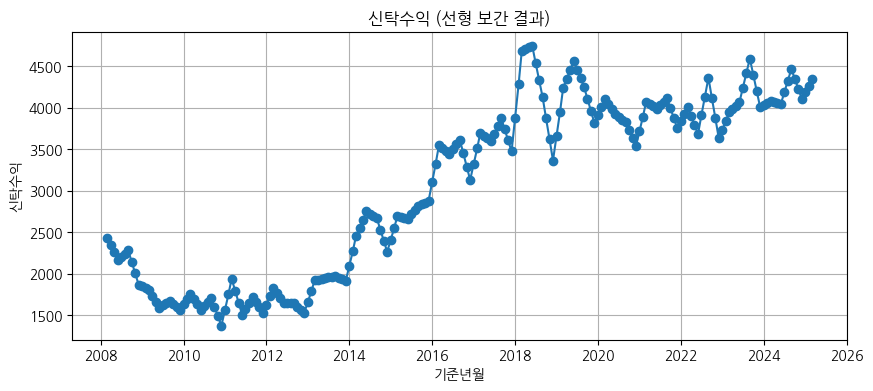

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(trust_target_df["기준년월"], trust_target_df["신탁수익"], marker='o')
plt.title("신탁수익 (선형 보간 결과)")
plt.xlabel("기준년월")
plt.ylabel("신탁수익")
plt.grid(True)
plt.show()

# 유가증권 및 외환부문

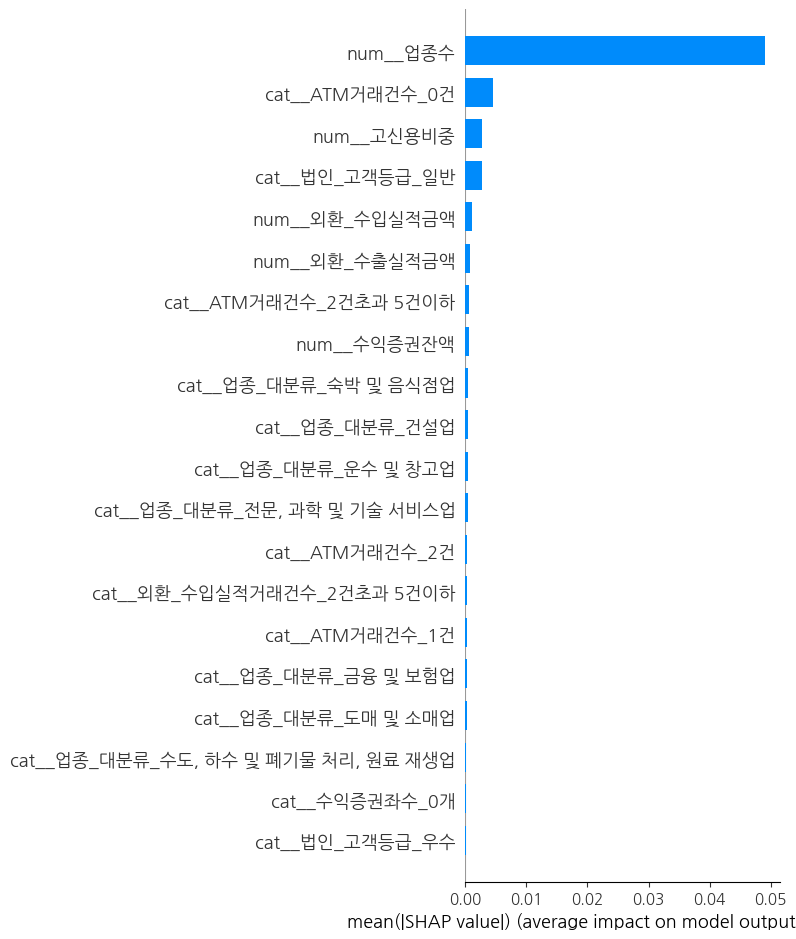


📌 유가+외환 수익 결정 변수 영향도 (SHAP 기준 Top 10)
                        변수  SHAP 영향력
4                 num__업종수  0.049083
23         cat__ATM거래건수_0건  0.004564
3               num__고신용비중  0.002673
34         cat__법인_고객등급_일반  0.002659
1           num__외환_수입실적금액  0.001023
0           num__외환_수출실적금액  0.000710
28  cat__ATM거래건수_2건초과 5건이하  0.000680
2              num__수익증권잔액  0.000530
15   cat__업종_대분류_숙박 및 음식점업  0.000481
5          cat__업종_대분류_건설업  0.000393


In [39]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 타깃 데이터: 유가증권+외환 수익 합산
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")

def format_target(df, colname):
    df = df.drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    df = df.T
    df.columns = [colname]
    df.index = pd.to_datetime(df.index, format="%Y년%m월")
    return df

sec_income = fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "유가증권 손익:당분기")]
fx_income = fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "외환관련 손익:당분기")]

sec_df = format_target(sec_income, "유가증권수익")
fx_df = format_target(fx_income, "외환수익")

total_df = sec_df.join(fx_df, how="outer").fillna(0)
total_df["유가외환수익"] = total_df["유가증권수익"] + total_df["외환수익"]
total_df = total_df[["유가외환수익"]].resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

# -----------------------------
# 2. 내부 데이터 불러오기
# -----------------------------
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

# -----------------------------
# 3. 병합 및 타깃 정의
# -----------------------------
merged = pd.merge(df, total_df, on="기준년월", how="inner")
merged = merged.dropna(subset=["유가외환수익"])
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")

# 결측치 및 0제외
merged = merged.dropna(subset=["유가외환수익", "고객수"])
merged = merged[merged["고객수"] > 0]

# 타깃 계산
merged["유가외환_per고객"] = merged["유가외환수익"] / merged["고객수"]

# 음수 또는 NaN 제거 (유가증권 손익에서 손실 등으로 음수 가능성 있음)
merged = merged[merged["유가외환_per고객"] > 0]
merged = merged.dropna(subset=["유가외환_per고객"])

# log 변환 후 y 구성
y = np.log1p(merged["유가외환_per고객"])

# -----------------------------
# 4. 설명변수 정의
# -----------------------------
merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "외환_수출실적금액", "외환_수입실적금액", 
    "외환_수출실적거래건수", "외환_수입실적거래건수",
    "수익증권좌수", "수익증권잔액", "ATM거래건수",
    "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]

X = merged[features]

# -----------------------------
# 5. 전처리 및 XGBoost 모델
# -----------------------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = list(set(features) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("xgb", xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42))
])

pipeline.fit(X, y)

# -----------------------------
# 6. SHAP 해석
# -----------------------------
explainer = shap.TreeExplainer(pipeline.named_steps["xgb"])
X_prepared = preprocessor.fit_transform(X)
shap_values = explainer.shap_values(X_prepared)

shap.summary_plot(
    shap_values,
    X_prepared,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="bar"
)

# -----------------------------
# 7. 변수 영향도 테이블 출력
# -----------------------------
mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    "변수": preprocessor.get_feature_names_out(),
    "SHAP 영향력": mean_abs_shap
}).sort_values(by="SHAP 영향력", ascending=False)

print("\n📌 유가+외환 수익 결정 변수 영향도 (SHAP 기준 Top 10)")
print(importance_df.head(10))

## 📌 SHAP 결과 해석 요약
| 순위  | 변수                  | SHAP 영향력   | 해석                                                  |
| --- | ------------------- | ---------- | --------------------------------------------------- |
| 1️⃣ | `업종수`               | **0.0491** | **업종 다양성이 유가+외환 수익 결정에 가장 큰 영향** → 다양한 고객군 확보 전략 필요 |
| 2️⃣ | `ATM거래건수_0건`        | 0.00456    | ATM 없는 고객은 상대적으로 수익 낮음 → **ATM 접근성, 이용채널 다변화 중요**   |
| 3️⃣ | `고신용비중`             | 0.00267    | 우량 고객 비율이 클수록 유가·외환 수익 기여 ↑                         |
| 4️⃣ | `법인_고객등급_일반`        | 0.00266    | 일반 고객군도 일정 수익 기여 있음 → 중간 고객군 타깃 활용 가능               |
| 5️⃣ | `외환_수입실적금액`         | 0.00102    | 외환 수입 규모 클수록 수익 연결 → 외화입금 기업 유치 전략 유효               |
| 6️⃣ | `외환_수출실적금액`         | 0.00071    | 수출 실적도 수익 기여 있으나 수입보다 영향 작음                         |
| 7️⃣ | `ATM거래건수_2건초과 5건이하` | 0.00068    | ATM 소거래 이용군도 일정 기여                                  |
| 8️⃣ | `수익증권잔액`            | 0.00053    | 유가증권 투자 잔액이 수익성과 연결됨 → 투자형 고객 주목 필요                 |
| 9️⃣ | `업종_숙박 및 음식점업`      | 0.00048    | 특정 업종군에서의 수익 기여 존재                                  |
| 🔟  | `업종_건설업`            | 0.00039    | 건설업 법인군도 수익에 일정 영향력                                 |

## 🎯 정책 설계 타깃 도출 예시
| 정책 제안                             | 근거 변수                | 기대 효과                                       |
| --------------------------------- | -------------------- | ------------------------------------------- |
| 🏢 **업종 다양성 기반 거래처 확대 전략**        | `업종수`                | 유가+외환 수익의 핵심 기여 요인 → **고객 풀 다변화 통한 리스크 분산** |
| 💳 **ATM 채널 이용 활성화 유도**           | `ATM거래건수_0건`, `2~5건` | 디지털+현장 채널 연계 전략 → **수익 유입 경로 확대**           |
| 🧠 **우량 고객 대상 외환·투자 연계 상품 제안**    | `고신용비중`, `수익증권잔액`    | 고신용 고객의 자산 운용 니즈 공략 → **비이자수익 극대화 가능**      |
| 💼 **외환 수입 실적 높은 기업 집중 유치 전략**    | `외환_수입실적금액`          | **해외매입 기업 대상 외환우대 정책 설계** 가능                |
| ⚖️ **일반 등급 고객 대상 ‘중위위험’ 외환상품 제안** | `법인_고객등급_일반`         | 잠재 고객층 타깃 확대 → **기저 고객 기반 수익 안정화**          |

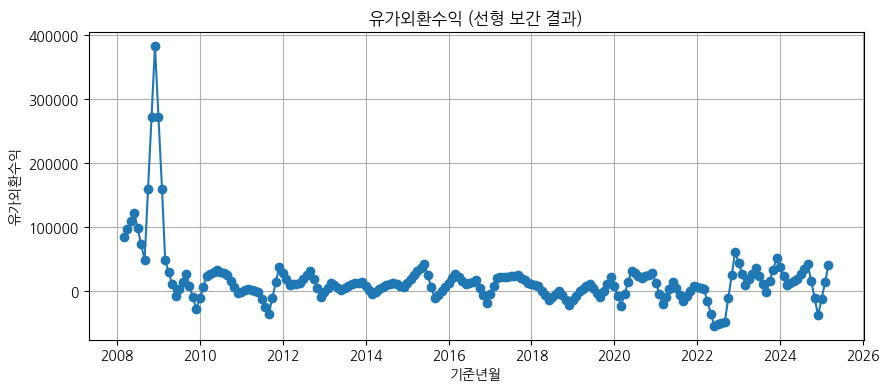

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(total_df["기준년월"], total_df["유가외환수익"], marker='o')
plt.title("유가외환수익 (선형 보간 결과)")
plt.xlabel("기준년월")
plt.ylabel("유가외환수익")
plt.grid(True)
plt.show()

# 판관비

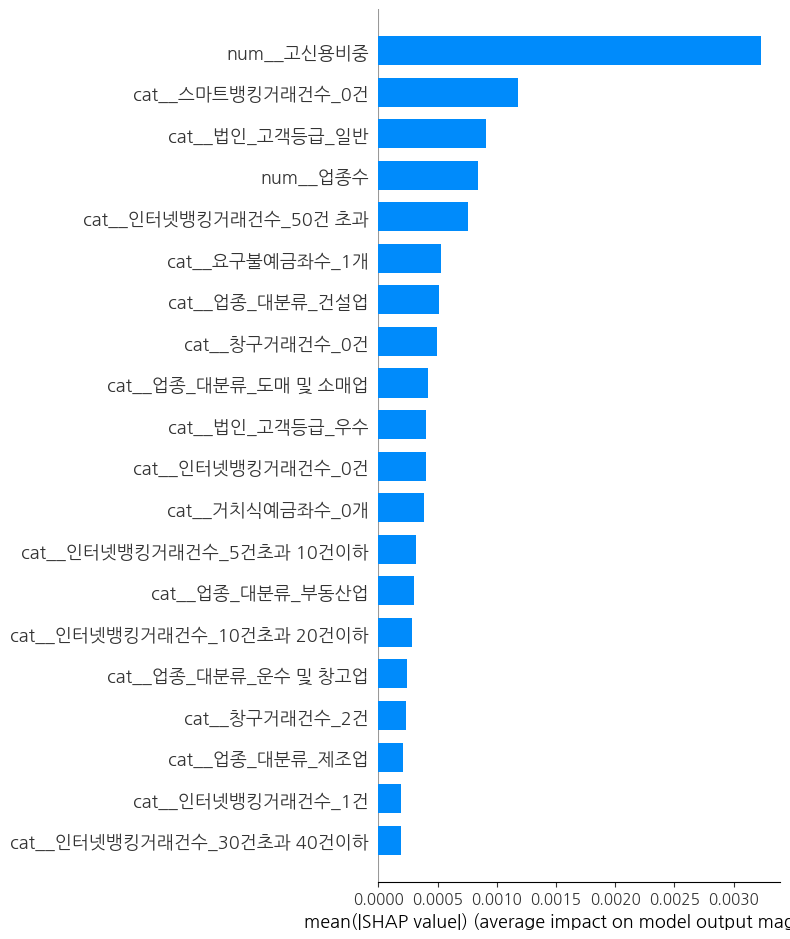


📌 판관비 결정 변수 영향도 (SHAP 기준 Top 10)
                       변수  SHAP 영향력
0              num__고신용비중  0.003231
20      cat__스마트뱅킹거래건수_0건  0.001181
51        cat__법인_고객등급_일반  0.000907
1                num__업종수  0.000840
48  cat__인터넷뱅킹거래건수_50건 초과  0.000757
55        cat__요구불예금좌수_1개  0.000529
2         cat__업종_대분류_건설업  0.000510
71         cat__창구거래건수_0건  0.000491
7    cat__업종_대분류_도매 및 소매업  0.000420
50        cat__법인_고객등급_우수  0.000405


In [46]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 타깃 데이터: 판관비 불러오기
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")

target_df = (
    fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "판매비와 관리비:당분기")]
    .drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    .T.rename(columns={fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "판매비와 관리비:당분기")].index[0]: "판관비"})
)

target_df.index = pd.to_datetime(target_df.index, format="%Y년%m월")
target_df = target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

# -----------------------------
# 2. 내부 데이터 불러오기
# -----------------------------
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

# -----------------------------
# 3. 병합 및 타깃 생성
# -----------------------------
merged = pd.merge(df, target_df, on="기준년월", how="inner")
merged = merged.dropna(subset=["판관비"])
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]

merged["판관비_per고객"] = merged["판관비"] / merged["고객수"]
merged = merged[merged["판관비_per고객"] > 0]
y = np.log1p(merged["판관비_per고객"])

# -----------------------------
# 4. 설명변수 정의
# -----------------------------
merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "창구거래건수", "인터넷뱅킹거래건수", "스마트뱅킹거래건수",
    "요구불예금좌수", "적립식예금좌수", "거치식예금좌수",
    "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]

X = merged[features]

# -----------------------------
# 5. 전처리 및 XGBoost 학습
# -----------------------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = list(set(features) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("xgb", xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42))
])

pipeline.fit(X, y)

# -----------------------------
# 6. SHAP 해석
# -----------------------------
explainer = shap.TreeExplainer(pipeline.named_steps["xgb"])
X_prepared = preprocessor.fit_transform(X)
shap_values = explainer.shap_values(X_prepared)

shap.summary_plot(
    shap_values,
    X_prepared,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="bar"
)

# -----------------------------
# 7. 변수 영향도 출력
# -----------------------------
mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    "변수": preprocessor.get_feature_names_out(),
    "SHAP 영향력": mean_abs_shap
}).sort_values(by="SHAP 영향력", ascending=False)

print("\n📌 판관비 결정 변수 영향도 (SHAP 기준 Top 10)")
print(importance_df.head(10))

## 📌 SHAP 결과 해석 요약
| 순위  | 변수명                | 영향도    | 해석                                            |
| --- | ------------------ | ------ | --------------------------------------------- |
| 1️⃣ | `고신용비중`            | 0.0032 | **우량 고객 비중 높을수록 판관비 낮음** → 우량 중심 영업 효율성 향상 가능 |
| 2️⃣ | `스마트뱅킹거래건수_0건`     | 0.0012 | 스마트뱅킹 미이용 고객의 **비용 부담이 큼** → **디지털 전환 유도** 필요 |
| 3️⃣ | `법인_고객등급_일반`       | 0.0009 | 일반 고객군은 판관비 부담 상대적으로 큼                        |
| 4️⃣ | `업종수`              | 0.0008 | 업종이 다양할수록 판관비 다소 증가 → **운용 복잡도 증가 시사**        |
| 5️⃣ | `인터넷뱅킹거래건수_50건 초과` | 0.0008 | 거래량 많은 고객이 오히려 판관비 효율적 사용 가능                  |
| 6️⃣ | `요구불예금좌수_1개`       | 0.0005 | 최소 보유 고객의 비용 기여 확인                            |
| 7️⃣ | `업종_건설업`           | 0.0005 | 특정 업종군에서 비용 구조 상 차이 존재                        |
| 8️⃣ | `창구거래건수_0건`        | 0.0005 | **비대면 채널만 사용하는 고객이 더 효율적일 수도 있음**             |
| 9️⃣ | `업종_도소매업`          | 0.0004 | 판관비 부담 높은 업종군 하나로 확인됨                         |
| 🔟  | `법인_고객등급_우수`       | 0.0004 | 우수 고객군은 상대적으로 효율적인 비용 구조                      |


## 🎯 정책 설계 타깃 도출 예시
| 정책 제안                                 | 근거 변수                   | 기대 효과                      |
| ------------------------------------- | ----------------------- | -------------------------- |
| 🟢 **고신용 고객 유치 및 유지 전략 강화**           | `고신용비중`, `고객등급_우수`      | 판관비 효율적 운영 가능 → **수익성 개선** |
| 🟢 **스마트뱅킹 미이용 고객 디지털 전환 유도**         | `스마트뱅킹거래건수_0건`          | 비용 절감 유도 + 채널 효율성 확보       |
| 🟡 **일반 고객 등급 전환 유도 (전담 관리 or 디지털화)** | `법인_고객등급_일반`            | 비용 부담 고객군의 리디자인 필요         |
| 🟡 **업종 다양성 고려한 비용구조 개선 방안**          | `업종수`, `업종_건설업`, `도소매업` | 운영 전략 업종별 맞춤화 고려           |
| 🟡 **창구 비이용 고객 특성 분석 통한 채널 비용 최적화**   | `창구거래건수_0건`             | 오프라인 점포 운영 전략에 반영 가능       |


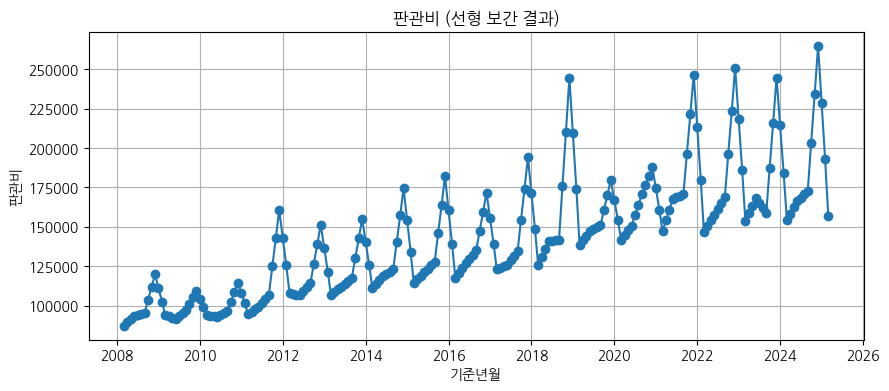

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(target_df["기준년월"], target_df["판관비"], marker='o')
plt.title("판관비 (선형 보간 결과)")
plt.xlabel("기준년월")
plt.ylabel("판관비")
plt.grid(True)
plt.show()

# 수수료 - XGB, LGBM, RF 비교 + SHAP

In [5]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 수수료 수익 타깃 로딩
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")

fee_target_df = (
    fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "수수료수익:당분기")]
    .drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    .T.rename(columns={fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "수수료수익:당분기")].index[0]: "수수료수익"})
)
fee_target_df.index = pd.to_datetime(fee_target_df.index, format="%Y년%m월")
fee_target_df = fee_target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})


df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

merged = pd.merge(df, fee_target_df, on="기준년월", how="inner").dropna(subset=["수수료수익"])
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]


merged["수수료_per고객"] = merged["수수료수익"] / merged["고객수"]
y = np.log1p(merged["수수료_per고객"])

merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "요구불예금잔액", "자동이체금액", "스마트뱅킹거래금액",
    "인터넷뱅킹거래금액", "신용카드사용금액", "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]
X = merged[features]


# 필요시: SHAP용 샘플 데이터 축소
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

# -------------------------
# 2. 공통 전처리 정의
# -------------------------
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# -------------------------
# 3. 모델 정의 및 학습
# -------------------------
models = {
    "XGBoost": xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, max_depth=4, random_state=42, force_col_wise=True),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
}

top_features = {}

for name, model in models.items():
    print(f"\n▶ 모델: {name}")
    
    pipeline = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_sample, y_sample)
    
    # SHAP explainer (빠르게)
    X_transformed = preprocessor.fit_transform(X_sample)
    explainer = shap.Explainer(pipeline.named_steps["model"], X_transformed, feature_names=preprocessor.get_feature_names_out(), algorithm="tree")
    shap_values = explainer(X_transformed)

    # SHAP 영향력 상위 변수
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    shap_df = pd.DataFrame({
        "변수": preprocessor.get_feature_names_out(),
        "SHAP 영향력": mean_abs_shap
    }).sort_values(by="SHAP 영향력", ascending=False)

    print(shap_df.head(10))
    top_features[name] = shap_df["변수"].head(10).tolist()

# -------------------------
# 4. 변수 일치도 비교
# -------------------------
print("\n🔍 모델 간 SHAP Top10 변수 일치도")

xgb_set = set(top_features["XGBoost"])
lgb_set = set(top_features["LightGBM"])
rf_set = set(top_features["RandomForest"])

print(f"XGBoost ∩ LightGBM: {len(xgb_set & lgb_set)}개 → {xgb_set & lgb_set}")
print(f"XGBoost ∩ RF:        {len(xgb_set & rf_set)}개 → {xgb_set & rf_set}")
print(f"LightGBM ∩ RF:       {len(lgb_set & rf_set)}개 → {lgb_set & rf_set}")
print(f"세 모델 공통 변수:    {len(xgb_set & lgb_set & rf_set)}개 → {xgb_set & lgb_set & rf_set}")


▶ 모델: XGBoost
                      변수  SHAP 영향력
1            num__자동이체금액  0.009735
3         num__인터넷뱅킹거래금액  0.007636
0           num__요구불예금잔액  0.007021
4          num__신용카드사용금액  0.006795
2         num__스마트뱅킹거래금액  0.004131
5             num__고신용비중  0.002860
24       cat__법인_고객등급_우수  0.001710
22       cat__업종_대분류_제조업  0.001389
13      cat__업종_대분류_부동산업  0.001251
11  cat__업종_대분류_도매 및 소매업  0.001216

▶ 모델: LightGBM
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 13
[LightGBM] [Info] Start training from score 1.489615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [8]:
xgb_set

{'cat__법인_고객등급_우수',
 'cat__업종_대분류_도매 및 소매업',
 'cat__업종_대분류_부동산업',
 'cat__업종_대분류_제조업',
 'num__고신용비중',
 'num__스마트뱅킹거래금액',
 'num__신용카드사용금액',
 'num__요구불예금잔액',
 'num__인터넷뱅킹거래금액',
 'num__자동이체금액'}

In [23]:
# 전처리된 전체 설명변수명 리스트
full_features = preprocessor.get_feature_names_out()

print("🧾 전체 설명변수 개수:", len(full_features))
print("🧾 전체 설명변수 목록:")
for f in full_features:
    print(f)

🧾 전체 설명변수 개수: 27
🧾 전체 설명변수 목록:
num__요구불예금잔액
num__자동이체금액
num__스마트뱅킹거래금액
num__인터넷뱅킹거래금액
num__신용카드사용금액
num__고신용비중
num__업종수
cat__업종_대분류_건설업
cat__업종_대분류_교육 서비스업
cat__업종_대분류_금융 및 보험업
cat__업종_대분류_농업, 임업 및 어업
cat__업종_대분류_도매 및 소매업
cat__업종_대분류_보건업 및 사회복지 서비스업
cat__업종_대분류_부동산업
cat__업종_대분류_사업시설 관리, 사업 지원 및 임대 서비스업
cat__업종_대분류_수도, 하수 및 폐기물 처리, 원료 재생업
cat__업종_대분류_숙박 및 음식점업
cat__업종_대분류_예술, 스포츠 및 여가관련 서비스업
cat__업종_대분류_운수 및 창고업
cat__업종_대분류_전기, 가스, 증기 및 공기조절 공급업
cat__업종_대분류_전문, 과학 및 기술 서비스업
cat__업종_대분류_정보통신업
cat__업종_대분류_제조업
cat__업종_대분류_협회 및 단체, 수리 및 기타 개인 서비스업
cat__법인_고객등급_우수
cat__법인_고객등급_일반
cat__법인_고객등급_최우수


In [9]:
import pandas as pd

# 예시로 각 모델의 SHAP Top10 변수 리스트
xgb_top10 = set(top_features["XGBoost"])
lgbm_top10 = set(top_features["LightGBM"])
rf_top10 = set(top_features["RandomForest"])

# 모든 변수들의 전체 집합
all_top_vars = sorted(xgb_top10 | lgbm_top10 | rf_top10)

# 교차표 생성
overlap_df = pd.DataFrame({
    "변수": all_top_vars,
    "XGBoost": [var in xgb_top10 for var in all_top_vars],
    "LightGBM": [var in lgbm_top10 for var in all_top_vars],
    "RandomForest": [var in rf_top10 for var in all_top_vars],
})

# 보기 좋게 ✔/✘ 마킹
display_df = overlap_df.copy()
for col in ["XGBoost", "LightGBM", "RandomForest"]:
    display_df[col] = display_df[col].map({True: "✔", False: "✘"})

print("📋 모델별 SHAP Top10 변수 교차 포함 여부")
display(display_df)

📋 모델별 SHAP Top10 변수 교차 포함 여부


,변수,XGBoost,LightGBM,RandomForest
0,cat__법인_고객등급_우수,✔,✘,✘
1,cat__법인_고객등급_일반,✘,✔,✘
2,cat__업종_대분류_건설업,✘,✔,✔
3,cat__업종_대분류_도매 및 소매업,✔,✘,✘
4,cat__업종_대분류_부동산업,✔,✔,✔
5,"cat__업종_대분류_예술, 스포츠 및 여가관련 서비스업",✘,✘,✔
6,cat__업종_대분류_제조업,✔,✔,✔
7,num__고신용비중,✔,✔,✔
8,num__스마트뱅킹거래금액,✔,✔,✔
9,num__신용카드사용금액,✔,✔,✔


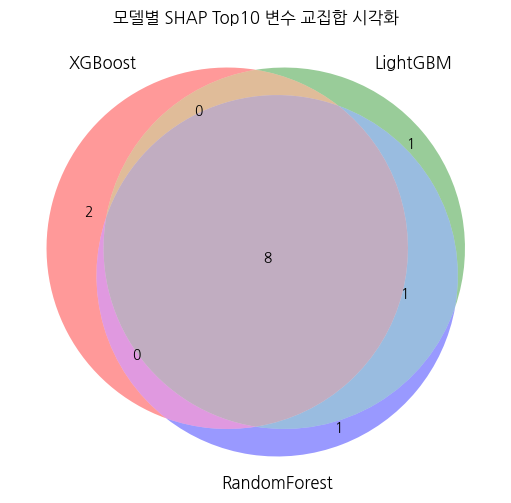

In [13]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
venn3([xgb_top10, lgbm_top10, rf_top10], 
      set_labels=("XGBoost", "LightGBM", "RandomForest"))
plt.title("모델별 SHAP Top10 변수 교집합 시각화")
plt.show()

# 신탁 - XGB, LGBM, RF 비교 + SHAP

In [26]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 신탁 수익 타깃 로딩
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")

trust_target_df = (
    fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "신탁(은행계정) 관련 손익:당분기")]
    .drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    .T.rename(columns={fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "신탁(은행계정) 관련 손익:당분기")].index[0]: "신탁수익"})
)
trust_target_df.index = pd.to_datetime(trust_target_df.index, format="%Y년%m월")
trust_target_df = trust_target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

merged = pd.merge(df, trust_target_df, on="기준년월", how="inner").dropna(subset=["신탁수익"])
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]

merged["신탁_per고객"] = merged["신탁수익"] / merged["고객수"]
y = np.log1p(merged["신탁_per고객"])

merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "신탁잔액", "퇴직연금잔액", "수익증권잔액", "거치식예금잔액", 
    "퇴직연금좌수", "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]
X = merged[features]

# SHAP용 샘플 데이터 축소
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

# -------------------------
# 2. 전처리 정의
# -------------------------
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# -------------------------
# 3. 모델 정의 및 학습
# -------------------------
models = {
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=4, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, max_depth=4, random_state=42, force_col_wise=True),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
}

top_features = {}

for name, model in models.items():
    print(f"\n▶ 모델: {name}")
    
    pipeline = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_sample, y_sample)
    
    X_transformed = preprocessor.fit_transform(X_sample)
    explainer = shap.TreeExplainer(pipeline.named_steps["model"])
    shap_values = explainer.shap_values(X_transformed)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        "변수": preprocessor.get_feature_names_out(),
        "SHAP 영향력": mean_abs_shap
    }).sort_values(by="SHAP 영향력", ascending=False)

    print(shap_df.head(10))
    top_features[name] = shap_df["변수"].head(10).tolist()

# -------------------------
# 4. 변수 일치도 비교
# -------------------------
print("\n🔍 모델 간 SHAP Top10 변수 일치도")

xgb_set = set(top_features["XGBoost"])
lgb_set = set(top_features["LightGBM"])
rf_set = set(top_features["RandomForest"])

print(f"XGBoost ∩ LightGBM: {len(xgb_set & lgb_set)}개 → {xgb_set & lgb_set}")
print(f"XGBoost ∩ RF:        {len(xgb_set & rf_set)}개 → {xgb_set & rf_set}")
print(f"LightGBM ∩ RF:       {len(lgb_set & rf_set)}개 → {lgb_set & rf_set}")
print(f"세 모델 공통 변수:    {len(xgb_set & lgb_set & rf_set)}개 → {xgb_set & lgb_set & rf_set}")


▶ 모델: XGBoost
                  변수  SHAP 영향력
0          num__신탁잔액  0.001846
7    cat__법인_고객등급_일반  0.001701
1        num__퇴직연금잔액  0.001608
26    cat__퇴직연금좌수_0개  0.001578
4         num__고신용비중  0.000932
15  cat__업종_대분류_부동산업  0.000860
6    cat__법인_고객등급_우수  0.000746
5           num__업종수  0.000692
3       num__거치식예금잔액  0.000535
24   cat__업종_대분류_제조업  0.000487

▶ 모델: LightGBM
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 13
[LightGBM] [Info] Start training from score 0.351943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [27]:
# 전처리된 전체 설명변수명 리스트
full_features = preprocessor.get_feature_names_out()

print("🧾 전체 설명변수 개수:", len(full_features))
print("🧾 전체 설명변수 목록:")
for f in full_features:
    print(f)

🧾 전체 설명변수 개수: 29
🧾 전체 설명변수 목록:
num__신탁잔액
num__퇴직연금잔액
num__수익증권잔액
num__거치식예금잔액
num__고신용비중
num__업종수
cat__법인_고객등급_우수
cat__법인_고객등급_일반
cat__법인_고객등급_최우수
cat__업종_대분류_건설업
cat__업종_대분류_교육 서비스업
cat__업종_대분류_금융 및 보험업
cat__업종_대분류_농업, 임업 및 어업
cat__업종_대분류_도매 및 소매업
cat__업종_대분류_보건업 및 사회복지 서비스업
cat__업종_대분류_부동산업
cat__업종_대분류_사업시설 관리, 사업 지원 및 임대 서비스업
cat__업종_대분류_수도, 하수 및 폐기물 처리, 원료 재생업
cat__업종_대분류_숙박 및 음식점업
cat__업종_대분류_예술, 스포츠 및 여가관련 서비스업
cat__업종_대분류_운수 및 창고업
cat__업종_대분류_전기, 가스, 증기 및 공기조절 공급업
cat__업종_대분류_전문, 과학 및 기술 서비스업
cat__업종_대분류_정보통신업
cat__업종_대분류_제조업
cat__업종_대분류_협회 및 단체, 수리 및 기타 개인 서비스업
cat__퇴직연금좌수_0개
cat__퇴직연금좌수_1개
cat__퇴직연금좌수_2개


In [28]:
import pandas as pd

# 예시로 각 모델의 SHAP Top10 변수 리스트
xgb_top10 = set(top_features["XGBoost"])
lgbm_top10 = set(top_features["LightGBM"])
rf_top10 = set(top_features["RandomForest"])

# 모든 변수들의 전체 집합
all_top_vars = sorted(xgb_top10 | lgbm_top10 | rf_top10)

# 교차표 생성
overlap_df = pd.DataFrame({
    "변수": all_top_vars,
    "XGBoost": [var in xgb_top10 for var in all_top_vars],
    "LightGBM": [var in lgbm_top10 for var in all_top_vars],
    "RandomForest": [var in rf_top10 for var in all_top_vars],
})

# 보기 좋게 ✔/✘ 마킹
display_df = overlap_df.copy()
for col in ["XGBoost", "LightGBM", "RandomForest"]:
    display_df[col] = display_df[col].map({True: "✔", False: "✘"})

print("📋 모델별 SHAP Top10 변수 교차 포함 여부")
display(display_df)

📋 모델별 SHAP Top10 변수 교차 포함 여부


,변수,XGBoost,LightGBM,RandomForest
0,cat__법인_고객등급_우수,✔,✔,✘
1,cat__법인_고객등급_일반,✔,✔,✔
2,cat__법인_고객등급_최우수,✘,✘,✔
3,cat__업종_대분류_부동산업,✔,✔,✔
4,cat__업종_대분류_제조업,✔,✔,✘
5,cat__퇴직연금좌수_0개,✔,✔,✔
6,cat__퇴직연금좌수_1개,✘,✔,✔
7,num__거치식예금잔액,✔,✔,✔
8,num__고신용비중,✔,✔,✘
9,num__수익증권잔액,✘,✘,✔


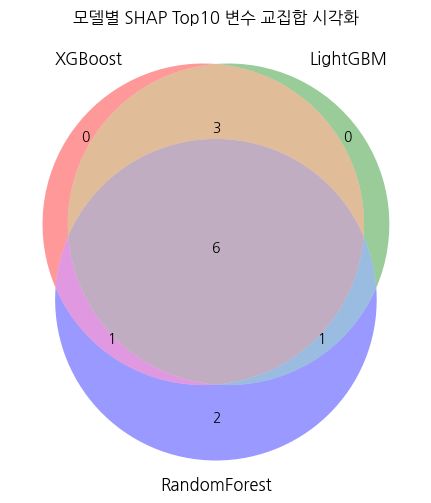

In [29]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
venn3([xgb_top10, lgbm_top10, rf_top10], 
      set_labels=("XGBoost", "LightGBM", "RandomForest"))
plt.title("모델별 SHAP Top10 변수 교집합 시각화")
plt.show()

# 유가증권 및 외환부문 - XGB, LGBM, RF 비교 + SHAP

In [36]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 유가증권+외환 수익 타깃 구성
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")

def format_target(df, colname):
    df = df.drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    df = df.T
    df.columns = [colname]
    df.index = pd.to_datetime(df.index, format="%Y년%m월")
    return df

sec_income = fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "유가증권 손익:당분기")]
fx_income = fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "외환관련 손익:당분기")]

sec_df = format_target(sec_income, "유가증권수익")
fx_df = format_target(fx_income, "외환수익")

total_df = sec_df.join(fx_df, how="outer").fillna(0)
total_df["유가외환수익"] = total_df["유가증권수익"] + total_df["외환수익"]
total_df = total_df[["유가외환수익"]].resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

# -----------------------------
# 2. 내부 데이터 불러오기 및 병합
# -----------------------------
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

merged = pd.merge(df, total_df, on="기준년월", how="inner").dropna(subset=["유가외환수익"])
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]

merged["유가외환_per고객"] = merged["유가외환수익"] / merged["고객수"]
merged = merged[merged["유가외환_per고객"] > 0].dropna(subset=["유가외환_per고객"])
y = np.log1p(merged["유가외환_per고객"])

# -----------------------------
# 3. 설명변수 정의
# -----------------------------
merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "외환_수출실적금액", "외환_수입실적금액", 
    "외환_수출실적거래건수", "외환_수입실적거래건수",
    "수익증권좌수", "수익증권잔액", "ATM거래건수",
    "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]
X = merged[features]

# -----------------------------
# 4. SHAP용 샘플 축소
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

# -----------------------------
# 5. 전처리 정의
# -----------------------------
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)  # <- 이 부분 수정
])

# -----------------------------
# 6. 모델 학습 및 SHAP 분석
# -----------------------------
models = {
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=4, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, max_depth=4, random_state=42, force_col_wise=True),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
}

top_features = {}

for name, model in models.items():
    print(f"\n▶ 모델: {name}")
    
    pipeline = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_sample, y_sample)
    
    X_transformed = preprocessor.fit_transform(X_sample)
    explainer = shap.Explainer(pipeline.named_steps["model"], X_transformed, feature_names=preprocessor.get_feature_names_out(), algorithm="tree")
    shap_values = explainer(X_transformed)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    shap_df = pd.DataFrame({
        "변수": preprocessor.get_feature_names_out(),
        "SHAP 영향력": mean_abs_shap
    }).sort_values(by="SHAP 영향력", ascending=False)

    print(shap_df.head(10))
    top_features[name] = shap_df["변수"].head(10).tolist()

# -----------------------------
# 7. 변수 일치도 비교 출력
# -----------------------------
print("\n🔍 모델 간 SHAP Top10 변수 일치도")

xgb_set = set(top_features["XGBoost"])
lgb_set = set(top_features["LightGBM"])
rf_set = set(top_features["RandomForest"])

print(f"XGBoost ∩ LightGBM: {len(xgb_set & lgb_set)}개 → {xgb_set & lgb_set}")
print(f"XGBoost ∩ RF:        {len(xgb_set & rf_set)}개 → {xgb_set & rf_set}")
print(f"LightGBM ∩ RF:       {len(lgb_set & rf_set)}개 → {lgb_set & rf_set}")
print(f"세 모델 공통 변수:    {len(xgb_set & lgb_set & rf_set)}개 → {xgb_set & lgb_set & rf_set}")


▶ 모델: XGBoost
                        변수  SHAP 영향력
4                 num__업종수  0.068592
24         cat__업종_대분류_건설업  0.030306
3               num__고신용비중  0.016740
46         cat__법인_고객등급_일반  0.014272
45         cat__법인_고객등급_우수  0.012803
40         cat__업종_대분류_제조업  0.010762
15  cat__ATM거래건수_2건초과 5건이하  0.010573
2              num__수익증권잔액  0.010513
29    cat__업종_대분류_도매 및 소매업  0.009871
14         cat__ATM거래건수_2건  0.009844

▶ 모델: LightGBM
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 13
[LightGBM] [Info] Start training from score 1.192313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [37]:
# 전처리된 전체 설명변수명 리스트
full_features = preprocessor.get_feature_names_out()

print("🧾 전체 설명변수 개수:", len(full_features))
print("🧾 전체 설명변수 목록:")
for f in full_features:
    print(f)

🧾 전체 설명변수 개수: 48
🧾 전체 설명변수 목록:
num__외환_수출실적금액
num__외환_수입실적금액
num__수익증권잔액
num__고신용비중
num__업종수
cat__수익증권좌수_0개
cat__수익증권좌수_1개
cat__수익증권좌수_2개
cat__수익증권좌수_2개초과 5개이하
cat__수익증권좌수_5개초과 10개이하
cat__ATM거래건수_0건
cat__ATM거래건수_10건초과 20건이하
cat__ATM거래건수_1건
cat__ATM거래건수_20건초과 30건이하
cat__ATM거래건수_2건
cat__ATM거래건수_2건초과 5건이하
cat__ATM거래건수_30건초과 40건이하
cat__ATM거래건수_50건 초과
cat__ATM거래건수_5건초과 10건이하
cat__외환_수입실적거래건수_0건
cat__외환_수입실적거래건수_10건초과 20건이하
cat__외환_수입실적거래건수_1건
cat__외환_수입실적거래건수_2건
cat__외환_수입실적거래건수_2건초과 5건이하
cat__업종_대분류_건설업
cat__업종_대분류_광업
cat__업종_대분류_교육 서비스업
cat__업종_대분류_금융 및 보험업
cat__업종_대분류_농업, 임업 및 어업
cat__업종_대분류_도매 및 소매업
cat__업종_대분류_보건업 및 사회복지 서비스업
cat__업종_대분류_부동산업
cat__업종_대분류_사업시설 관리, 사업 지원 및 임대 서비스업
cat__업종_대분류_수도, 하수 및 폐기물 처리, 원료 재생업
cat__업종_대분류_숙박 및 음식점업
cat__업종_대분류_예술, 스포츠 및 여가관련 서비스업
cat__업종_대분류_운수 및 창고업
cat__업종_대분류_전기, 가스, 증기 및 공기조절 공급업
cat__업종_대분류_전문, 과학 및 기술 서비스업
cat__업종_대분류_정보통신업
cat__업종_대분류_제조업
cat__업종_대분류_협회 및 단체, 수리 및 기타 개인 서비스업
cat__외환_수출실적거래건수_0건
cat__외환_수출실적거래건수_1건
cat__외환_수출실적거래건수_2건초과 5건이하


In [38]:
import pandas as pd

# 예시로 각 모델의 SHAP Top10 변수 리스트
xgb_top10 = set(top_features["XGBoost"])
lgbm_top10 = set(top_features["LightGBM"])
rf_top10 = set(top_features["RandomForest"])

# 모든 변수들의 전체 집합
all_top_vars = sorted(xgb_top10 | lgbm_top10 | rf_top10)

# 교차표 생성
overlap_df = pd.DataFrame({
    "변수": all_top_vars,
    "XGBoost": [var in xgb_top10 for var in all_top_vars],
    "LightGBM": [var in lgbm_top10 for var in all_top_vars],
    "RandomForest": [var in rf_top10 for var in all_top_vars],
})

# 보기 좋게 ✔/✘ 마킹
display_df = overlap_df.copy()
for col in ["XGBoost", "LightGBM", "RandomForest"]:
    display_df[col] = display_df[col].map({True: "✔", False: "✘"})

print("📋 모델별 SHAP Top10 변수 교차 포함 여부")
display(display_df)

📋 모델별 SHAP Top10 변수 교차 포함 여부


,변수,XGBoost,LightGBM,RandomForest
0,cat__ATM거래건수_0건,✘,✔,✘
1,cat__ATM거래건수_2건,✔,✔,✔
2,cat__ATM거래건수_2건초과 5건이하,✔,✔,✔
3,cat__법인_고객등급_우수,✔,✔,✘
4,cat__법인_고객등급_일반,✔,✘,✔
5,cat__업종_대분류_건설업,✔,✔,✔
6,cat__업종_대분류_도매 및 소매업,✔,✔,✔
7,cat__업종_대분류_부동산업,✘,✔,✘
8,"cat__업종_대분류_전기, 가스, 증기 및 공기조절 공급업",✘,✘,✔
9,"cat__업종_대분류_전문, 과학 및 기술 서비스업",✘,✘,✔


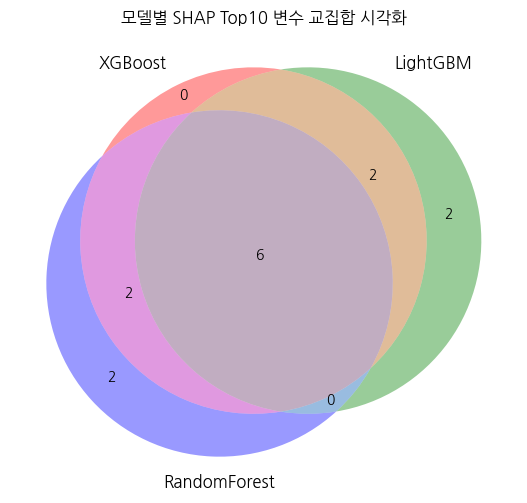

In [39]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
venn3([xgb_top10, lgbm_top10, rf_top10], 
      set_labels=("XGBoost", "LightGBM", "RandomForest"))
plt.title("모델별 SHAP Top10 변수 교집합 시각화")
plt.show()

# 판관비 - XGB, LGBM, RF 비교 + SHAP

In [47]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 타깃 데이터: 판관비 불러오기
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")

target_df = (
    fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "판매비와 관리비:당분기")]
    .drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    .T.rename(columns={fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "판매비와 관리비:당분기")].index[0]: "판관비"})
)
target_df.index = pd.to_datetime(target_df.index, format="%Y년%m월")
target_df = target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

# -----------------------------
# 2. 내부 데이터 불러오기 및 병합
# -----------------------------
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")
merged = pd.merge(df, target_df, on="기준년월", how="inner").dropna(subset=["판관비"])

merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]
merged["판관비_per고객"] = merged["판관비"] / merged["고객수"]
merged = merged[merged["판관비_per고객"] > 0].dropna(subset=["판관비_per고객"])

y = np.log1p(merged["판관비_per고객"])

# -----------------------------
# 3. 설명변수 정의
# -----------------------------
merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "창구거래건수", "인터넷뱅킹거래건수", "스마트뱅킹거래건수",
    "요구불예금좌수", "적립식예금좌수", "거치식예금좌수",
    "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]
X = merged[features]

# -----------------------------
# 4. SHAP용 샘플 축소
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

# -----------------------------
# 5. 전처리 정의
# -----------------------------
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

# -----------------------------
# 6. 모델 학습 및 SHAP 분석
# -----------------------------
models = {
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=4, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, max_depth=4, random_state=42, force_col_wise=True),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
}

top_features = {}

for name, model in models.items():
    print(f"\n▶ 모델: {name}")
    
    pipeline = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_sample, y_sample)

    X_transformed = preprocessor.fit_transform(X_sample)
    explainer = shap.Explainer(pipeline.named_steps["model"], X_transformed, 
                               feature_names=preprocessor.get_feature_names_out(), algorithm="tree")
    shap_values = explainer(X_transformed)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    shap_df = pd.DataFrame({
        "변수": preprocessor.get_feature_names_out(),
        "SHAP 영향력": mean_abs_shap
    }).sort_values(by="SHAP 영향력", ascending=False)

    print(shap_df.head(10))
    top_features[name] = shap_df["변수"].head(10).tolist()

# -----------------------------
# 7. 변수 일치도 비교 출력
# -----------------------------
print("\n🔍 모델 간 SHAP Top10 변수 일치도")

xgb_set = set(top_features["XGBoost"])
lgb_set = set(top_features["LightGBM"])
rf_set = set(top_features["RandomForest"])

print(f"XGBoost ∩ LightGBM: {len(xgb_set & lgb_set)}개 → {xgb_set & lgb_set}")
print(f"XGBoost ∩ RF:        {len(xgb_set & rf_set)}개 → {xgb_set & rf_set}")
print(f"LightGBM ∩ RF:       {len(lgb_set & rf_set)}개 → {lgb_set & rf_set}")
print(f"세 모델 공통 변수:    {len(xgb_set & lgb_set & rf_set)}개 → {xgb_set & lgb_set & rf_set}")



▶ 모델: XGBoost
                            변수  SHAP 영향력
61           cat__인터넷뱅킹거래건수_0건  0.011350
0                   num__고신용비중  0.009867
62  cat__인터넷뱅킹거래건수_10건초과 20건이하  0.009637
4              cat__요구불예금좌수_1개  0.007151
49             cat__법인_고객등급_일반  0.005606
46             cat__업종_대분류_제조업  0.005058
1                     num__업종수  0.005042
51           cat__스마트뱅킹거래건수_0건  0.004988
35        cat__업종_대분류_도매 및 소매업  0.004874
6              cat__요구불예금좌수_2개  0.004323

▶ 모델: LightGBM
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 33
[LightGBM] [Info] Start training from score 2.991370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [48]:
# 전처리된 전체 설명변수명 리스트
full_features = preprocessor.get_feature_names_out()

print("🧾 전체 설명변수 개수:", len(full_features))
print("🧾 전체 설명변수 목록:")
for f in full_features:
    print(f)

🧾 전체 설명변수 개수: 71
🧾 전체 설명변수 목록:
num__고신용비중
num__업종수
cat__요구불예금좌수_0개
cat__요구불예금좌수_10개초과 20개이하
cat__요구불예금좌수_1개
cat__요구불예금좌수_20개초과 30개이하
cat__요구불예금좌수_2개
cat__요구불예금좌수_2개초과 5개이하
cat__요구불예금좌수_30개초과 40개이하
cat__요구불예금좌수_50개 초과
cat__요구불예금좌수_5개초과 10개이하
cat__거치식예금좌수_0개
cat__거치식예금좌수_10개초과 20개이하
cat__거치식예금좌수_1개
cat__거치식예금좌수_2개
cat__거치식예금좌수_2개초과 5개이하
cat__적립식예금좌수_0개
cat__적립식예금좌수_1개
cat__적립식예금좌수_2개
cat__적립식예금좌수_2개초과 5개이하
cat__적립식예금좌수_5개초과 10개이하
cat__창구거래건수_0건
cat__창구거래건수_10건초과 20건이하
cat__창구거래건수_1건
cat__창구거래건수_20건초과 30건이하
cat__창구거래건수_2건
cat__창구거래건수_2건초과 5건이하
cat__창구거래건수_30건초과 40건이하
cat__창구거래건수_40건초과 50건이하
cat__창구거래건수_50건 초과
cat__창구거래건수_5건초과 10건이하
cat__업종_대분류_건설업
cat__업종_대분류_교육 서비스업
cat__업종_대분류_금융 및 보험업
cat__업종_대분류_농업, 임업 및 어업
cat__업종_대분류_도매 및 소매업
cat__업종_대분류_보건업 및 사회복지 서비스업
cat__업종_대분류_부동산업
cat__업종_대분류_사업시설 관리, 사업 지원 및 임대 서비스업
cat__업종_대분류_수도, 하수 및 폐기물 처리, 원료 재생업
cat__업종_대분류_숙박 및 음식점업
cat__업종_대분류_예술, 스포츠 및 여가관련 서비스업
cat__업종_대분류_운수 및 창고업
cat__업종_대분류_전기, 가스, 증기 및 공기조절 공급업
cat__업종_대분류_전문, 과학 및 기술 서비스업
cat__

In [49]:
import pandas as pd

# 예시로 각 모델의 SHAP Top10 변수 리스트
xgb_top10 = set(top_features["XGBoost"])
lgbm_top10 = set(top_features["LightGBM"])
rf_top10 = set(top_features["RandomForest"])

# 모든 변수들의 전체 집합
all_top_vars = sorted(xgb_top10 | lgbm_top10 | rf_top10)

# 교차표 생성
overlap_df = pd.DataFrame({
    "변수": all_top_vars,
    "XGBoost": [var in xgb_top10 for var in all_top_vars],
    "LightGBM": [var in lgbm_top10 for var in all_top_vars],
    "RandomForest": [var in rf_top10 for var in all_top_vars],
})

# 보기 좋게 ✔/✘ 마킹
display_df = overlap_df.copy()
for col in ["XGBoost", "LightGBM", "RandomForest"]:
    display_df[col] = display_df[col].map({True: "✔", False: "✘"})

print("📋 모델별 SHAP Top10 변수 교차 포함 여부")
display(display_df)

📋 모델별 SHAP Top10 변수 교차 포함 여부


,변수,XGBoost,LightGBM,RandomForest
0,cat__거치식예금좌수_0개,✘,✔,✔
1,cat__법인_고객등급_일반,✔,✘,✔
2,cat__스마트뱅킹거래건수_0건,✔,✔,✘
3,cat__스마트뱅킹거래건수_2건,✘,✘,✔
4,cat__스마트뱅킹거래건수_5건초과 10건이하,✘,✔,✔
5,cat__업종_대분류_건설업,✘,✔,✘
6,cat__업종_대분류_도매 및 소매업,✔,✘,✔
7,cat__업종_대분류_숙박 및 음식점업,✘,✘,✔
8,cat__업종_대분류_제조업,✔,✔,✘
9,cat__요구불예금좌수_1개,✔,✘,✘


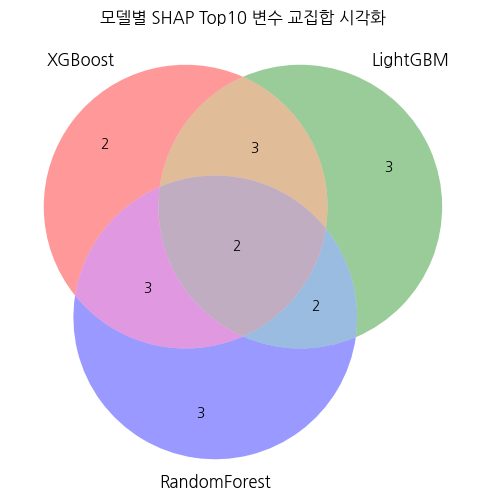

In [50]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
venn3([xgb_top10, lgbm_top10, rf_top10], 
      set_labels=("XGBoost", "LightGBM", "RandomForest"))
plt.title("모델별 SHAP Top10 변수 교집합 시각화")
plt.show()

# 정리

## 1️⃣ 모델 종류: 3가지 트리 기반 회귀 모델
| 모델명                                         | 설명                              | 특징                                                                                  |
| ------------------------------------------- | ------------------------------- | ----------------------------------------------------------------------------------- |
| **XGBoost** (`XGBRegressor`)                | eXtreme Gradient Boosting       | - Gradient Boosting 기반<br>- 정교한 정규화와 빠른 속도<br>- 과적합 방지에 유리                          |
| **LightGBM** (`LGBMRegressor`)              | Light Gradient Boosting Machine | - 큰 데이터에 최적화<br>- Leaf-wise 트리 성장 방식으로 예측 성능 우수<br>- `force_col_wise=True`로 병렬화 최적화 |
| **Random Forest** (`RandomForestRegressor`) | 배깅 기반 랜덤 트리 앙상블                 | - 각기 다른 데이터 Subset으로 트리 학습<br>- 변수 간 상호작용 고려는 약함<br>- 상대적으로 해석성 낮지만 안정적             |

📌 목적: 단일 모델 편향을 줄이고, 공통적 중요 변수 도출을 통해 정책 우선순위 타깃 변수 도출   

## 2️⃣ 분석 절차 요약
| 단계             | 설명                                                                                         |
| -------------- | ------------------------------------------------------------------------------------------ |
| **① 타깃 정의**    | `각 부문 수익 ÷ 고객 수`를 로그 변환하여 안정화된 타깃 `log1p(수익_per고객)` 생성                                     |
| **② 설명변수 구성**  | 내부 법인 데이터 기반 정량·범주형 변수 조합<br>예: `예금·거래건수`, `업종`, `고객등급`, `좌수`, `외환/수익증권`, `고신용비중`, `업종수` 등 |
| **③ 전처리**      | 수치형(`MinMaxScaler`) + 범주형(`OneHotEncoder`)을 `ColumnTransformer`로 처리                        |
| **④ SHAP 해석**  | 모델 학습 후, `shap.Explainer`를 통해 **각 feature가 예측에 기여한 크기(Shapley 값)** 추출                      |
| **⑤ 중요 변수 비교** | 3개 모델의 SHAP 영향력을 비교하여 **공통 상위 변수** 및 **모델별 차별 변수** 도출                                      |
   
## 3️⃣ SHAP 기반 중요 변수 분석
- SHAP(Shapley Additive Explanations):

게임이론 기반의 모델 해석 도구

각 변수의 예측값 기여도를 개별 샘플 기준으로 산출

모든 변수의 영향력을 정량적이고 공정하게 분해하여 제시함

- 분석 결과에서는:

모델 간 SHAP Top10 변수 교차 일치도를 분석

예: num__고신용비중, num__스마트뱅킹거래금액, cat__업종_대분류_제조업 등은 모든 모델에서 공통적으로 중요 변수로 확인됨


## 4️⃣ SHAP 영향도 기반 결과 활용 예시
| 활용 목적                    | 설명                                       |
| ------------------------ | ---------------------------------------- |
| **전략 타깃 도출**             | 영향력 높은 변수 중심으로 **수익 증대 타깃 변수** 도출 가능     |
| **시뮬레이션 기반 정책 설계**       | SHAP이 높은 변수에 변화 시켰을 때 **수익 증가 시뮬레이션** 가능 |
| **고수익 은행 벤치마킹 기준 변수 선정** | 고수익 은행이 해당 변수 지표에서 높은 수치를 보이는지 비교 가능     |


## 📌 요약: 우리가 사용한 분석 방식은 다음과 같음
“트리 기반 회귀 모델 + SHAP 해석을 통해, 각 비이자 수익 부문별 주요 설명변수를 도출하고, 모델 간 일관성을 비교함으로써 수익 향상 전략에 활용 가능한 핵심 변수 세트를 제시하는 정량 분석”

# 타은행

In [60]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 판관비 타행 평균 타깃 구성
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")

major_banks = ['국민은행', '신한은행', '우리은행', '주식회사 하나은행', '한국스탠다드차타드은행', '한국씨티은행']

def build_target_df(bank_list, 항목명, colname):
    df = fisis[(fisis["회사명"].isin(bank_list)) & (fisis["항목"] == 항목명)]
    df = df.drop(columns=["회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    df = df.set_index("회사명").T
    df.index = pd.to_datetime(df.index, format="%Y년%m월", errors="coerce")
    df = df.apply(pd.to_numeric, errors="coerce")
    return df.mean(axis=1, skipna=True).to_frame(name=colname)

target_df = build_target_df(major_banks, "판매비와 관리비:당분기", "판관비")
target_df = target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

# -----------------------------
# 2. 내부 데이터 병합 및 타깃 계산
# -----------------------------
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

merged = pd.merge(df, target_df, on="기준년월", how="inner").dropna(subset=["판관비"])
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]
merged["판관비_per고객"] = merged["판관비"] / merged["고객수"]
merged = merged[merged["판관비_per고객"] > 0]

y = np.log1p(merged["판관비_per고객"])

# -----------------------------
# 3. 설명변수 정의
# -----------------------------
merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "창구거래건수", "인터넷뱅킹거래건수", "스마트뱅킹거래건수",
    "요구불예금좌수", "적립식예금좌수", "거치식예금좌수",
    "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]
X = merged[features]

# -----------------------------
# 4. SHAP용 샘플 축소
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

# -----------------------------
# 5. 전처리 정의
# -----------------------------
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

# -----------------------------
# 6. 모델 학습 및 SHAP 분석
# -----------------------------
models = {
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=4, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, max_depth=4, random_state=42, force_col_wise=True),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
}

top_features = {}

for name, model in models.items():
    print(f"\n▶ 모델: {name}")
    
    pipeline = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_sample, y_sample)

    X_transformed = preprocessor.fit_transform(X_sample)
    explainer = shap.Explainer(pipeline.named_steps["model"], X_transformed, 
                               feature_names=preprocessor.get_feature_names_out(), algorithm="tree")
    shap_values = explainer(X_transformed)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    shap_df = pd.DataFrame({
        "변수": preprocessor.get_feature_names_out(),
        "SHAP 영향력": mean_abs_shap
    }).sort_values(by="SHAP 영향력", ascending=False)

    print(shap_df.head(10))
    top_features[name] = shap_df["변수"].head(10).tolist()

# -----------------------------
# 7. 변수 일치도 비교 출력
# -----------------------------
print("\n🔍 타행 평균 판관비 SHAP Top10 변수 일치도")

xgb_set = set(top_features["XGBoost"])
lgb_set = set(top_features["LightGBM"])
rf_set = set(top_features["RandomForest"])

print(f"XGBoost ∩ LightGBM: {len(xgb_set & lgb_set)}개 → {xgb_set & lgb_set}")
print(f"XGBoost ∩ RF:        {len(xgb_set & rf_set)}개 → {xgb_set & rf_set}")
print(f"LightGBM ∩ RF:       {len(lgb_set & rf_set)}개 → {lgb_set & rf_set}")
print(f"세 모델 공통 변수:    {len(xgb_set & lgb_set & rf_set)}개 → {xgb_set & lgb_set & rf_set}")



▶ 모델: XGBoost
                            변수  SHAP 영향력
1                     num__업종수  0.010711
62  cat__인터넷뱅킹거래건수_10건초과 20건이하  0.007272
4              cat__요구불예금좌수_1개  0.006646
51           cat__스마트뱅킹거래건수_0건  0.005677
6              cat__요구불예금좌수_2개  0.005303
35        cat__업종_대분류_도매 및 소매업  0.004493
49             cat__법인_고객등급_일반  0.003813
46             cat__업종_대분류_제조업  0.003804
48             cat__법인_고객등급_우수  0.003747
18             cat__적립식예금좌수_2개  0.003686

▶ 모델: LightGBM
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 33
[LightGBM] [Info] Start training from score 4.238753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [61]:
import pandas as pd

# 예시로 각 모델의 SHAP Top10 변수 리스트
xgb_top10 = set(top_features["XGBoost"])
lgbm_top10 = set(top_features["LightGBM"])
rf_top10 = set(top_features["RandomForest"])

# 모든 변수들의 전체 집합
all_top_vars = sorted(xgb_top10 | lgbm_top10 | rf_top10)

# 교차표 생성
overlap_df = pd.DataFrame({
    "변수": all_top_vars,
    "XGBoost": [var in xgb_top10 for var in all_top_vars],
    "LightGBM": [var in lgbm_top10 for var in all_top_vars],
    "RandomForest": [var in rf_top10 for var in all_top_vars],
})

# 보기 좋게 ✔/✘ 마킹
display_df = overlap_df.copy()
for col in ["XGBoost", "LightGBM", "RandomForest"]:
    display_df[col] = display_df[col].map({True: "✔", False: "✘"})

print("📋 모델별 SHAP Top10 변수 교차 포함 여부")
display(display_df)

📋 모델별 SHAP Top10 변수 교차 포함 여부


,변수,XGBoost,LightGBM,RandomForest
0,cat__법인_고객등급_우수,✔,✘,✘
1,cat__법인_고객등급_일반,✔,✔,✘
2,cat__스마트뱅킹거래건수_0건,✔,✔,✔
3,cat__스마트뱅킹거래건수_5건초과 10건이하,✘,✔,✘
4,cat__업종_대분류_건설업,✘,✘,✔
5,cat__업종_대분류_도매 및 소매업,✔,✔,✘
6,cat__업종_대분류_숙박 및 음식점업,✘,✘,✔
7,cat__업종_대분류_제조업,✔,✔,✔
8,cat__요구불예금좌수_1개,✔,✘,✔
9,cat__요구불예금좌수_2개,✔,✘,✘
